***Data Pre-Processor***


In [1]:
%run DeepFake_Dataloader.py
%run utils.py

In [2]:
import h5py
import torch
import numpy as np

In [4]:
batch_sz = 16
dataloader = get_preprocessors(batch_size=batch_sz)
total_imgs = len(dataloader) * batch_sz
print(total_imgs)

('Classes: '
 "['100KFake_10K', "
 "'Flickr-Faces-HQ_10K', "
 "'celebA-HQ_10K', "
 "'thispersondoesntexists_10K']")
('Indices: '
 "{'100KFake_10K': "
 '0, '
 "'Flickr-Faces-HQ_10K': "
 '1, '
 "'celebA-HQ_10K': "
 '2, '
 "'thispersondoesntexists_10K': "
 '3}')
40000


In [5]:
progress = ProgressMonitor(length=total_imgs)
with h5py.File('Faces_HQ.hdf5', 'w') as f:
    """
        Create HDF5 datasets 
    """
    data_dset = f.create_dataset('fft_data',  (total_imgs, 725), dtype='f')
    lbl_dset  = f.create_dataset('lbl_data',  (total_imgs,),     dtype='i')
    orgn_dset = f.create_dataset('orgn_data', (total_imgs,),     dtype='i')
    
    for i, (img_data, target, origin_dataset) in enumerate(dataloader):
        start_idx = i * batch_sz
        for j in range(batch_sz):
            idx = start_idx + j
            progress.update(1, 0)
            data_dset[idx] = img_data[j]
            lbl_dset[idx]  = target[j]
            orgn_dset[idx] = data_origin[origin_dataset[j]]

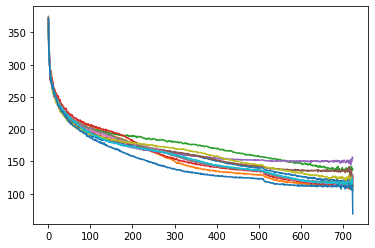

In [12]:
import matplotlib.pyplot as plt


with h5py.File('Faces_HQ.hdf5', 'r') as f:
    dset = f['fft_data']
    plt.plot(dset[39999])
    for i in range(10):
        plt.plot(dset[np.random.randint(40000)])
#         plt.show()
    plt.show()